In [1]:
import pandas as pd
import numpy as np
import shutil as sh
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator

import tensorflow.keras as keras
import tensorflow as tf


# These lines below are needed due to versioning issues with my Ubuntu system


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

### Versions and Packages:

I am using;
i7-9750H CPU
RTX2060mobile GPU
Lubuntu (LXQt 0.14.1 built on Ubuntu 19.10)

In [18]:
! conda list cudnn && conda list cudatoolkit && conda list tensorflow

# packages in environment at /home/houston/anaconda3:
#
# Name                    Version                   Build  Channel
cudnn                     7.6.5                cuda10.1_0  
# packages in environment at /home/houston/anaconda3:
#
# Name                    Version                   Build  Channel
cudatoolkit               10.1.243             h6bb024c_0  
# packages in environment at /home/houston/anaconda3:
#
# Name                    Version                   Build  Channel
tensorflow                2.1.0           gpu_py37h7a4bb67_0  
tensorflow-base           2.1.0           gpu_py37h6c5654b_0  
tensorflow-estimator      2.1.0              pyhd54b08b_0  
tensorflow-gpu            2.1.0                    pypi_0    pypi


### Read in Data:

First I'm going to read in my DataFrame containing my data.

And convert the rows into the format I will need to feed my model.

In [2]:
data_raw = pd.read_csv('./data/feed_dict.csv')

In [3]:
data = data_raw.sample(frac=1, random_state=42)

In [4]:
data['Language'] = [int(i) for i in data['Language']]

In [5]:
data['Language'] = [str(i) for i in data['Language']]

In [6]:
data

,Files,Names,Language,FilePath
33331,0_105-120_audio_to_img.jpg,J._Michael_Straczynski,0,./data/audio_images/German/german/J._Michael_S...
6915,0_270-285_audio_to_img.jpg,Shannon_Rutherford,1,./data/audio_images/English/english/Shannon_Ru...
1503,0_165-180_audio_to_img.jpg,Tommy_Wiseau,1,./data/audio_images/English/english/Tommy_Wise...
15241,0_0-15_audio_to_img.jpg,Saltine_cracker_challenge,1,./data/audio_images/English/english/Saltine_cr...
35306,0_240-255_audio_to_img.jpg,Hardware,0,./data/audio_images/German/german/Hardware/0_2...
...,...,...,...,...
6265,0_225-240_audio_to_img.jpg,Myst_III%3a_Exile,1,./data/audio_images/English/english/Myst_III%3...
11284,1_60-75_audio_to_img.jpg,Manchester,1,./data/audio_images/English/english/Manchester...
38158,0_255-270_audio_to_img.jpg,Charles-%c3%89douard_Brown-S%c3%a9quard,0,./data/audio_images/German/german/Charles-%c3%...
860,0_285-300_audio_to_img.jpg,Octavia_E._Butler,1,./data/audio_images/English/english/Octavia_E....


### Check Labels:

Check the distribution of my labels by running value counts on the Language column

In [7]:
data['Language'].value_counts()

1    23232
0    20207
Name: Language, dtype: int64

### Check values:

Next I am verifying that each path is unique and that the count for class labels is correct

In [8]:
len(set(data['FilePath']))

43439

In [9]:
len(set(data['Language']))

2

### Create Train, Test, and Val sets:

I'm reseting the index since the file I read in was jumbled. 

Then I'm using the index to split the shuffled DataFrame into different segments in order to build generator objects.

In [10]:
data.reset_index(inplace=True)

In [11]:
train_data = data.loc[:38438, :]
val_data = data.loc[38438:40938, :]
test_data = data.loc[40938:43438, :]

Now I create a generator that rescales the 256 color densities between 0 and 1. And create a generator for each of my splits.

I have to pass binary here since I am only predicting two classes and there is no need to shuffle since I already shuffled. (This will make it easier to check errors if necessary)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_gen = datagen.flow_from_dataframe(dataframe=train_data,
                                        x_col='FilePath',
                                        y_col='Language',
                                        batch_size= 64,
                                        shuffle= False,
                                        class_mode='binary',
                                        target_size=(128, 128))

test_gen = datagen.flow_from_dataframe(dataframe=test_data,
                                       x_col='FilePath',
                                       y_col='Language',
                                       batch_size= 64,
                                       shuffle= False,
                                       class_mode='binary',
                                       target_size=(128, 128))

val_gen = datagen.flow_from_dataframe(dataframe=val_data,
                                      x_col='FilePath',
                                      y_col='Language',
                                      batch_size= 64,
                                      shuffle= False,
                                      class_mode='binary',
                                      target_size=(128, 128))

Found 38435 validated image filenames belonging to 2 classes.
Found 2501 validated image filenames belonging to 2 classes.
Found 2501 validated image filenames belonging to 2 classes.


/home/houston/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="FilePath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Model:

#### The fun part!!

Now that the data is fully prepped to go into my model I can finally build the model.

I'm going to build a 2D convolutional neural network to handle this problem. 

I build my convolutions by following an equation to make sure each layer adds up evenly. (Inputs - Kernel + 2 * Padding) / Strides + 1

I want to make sure that each layer works without wasting any of the edge data and that I can feed them evenly into the next layer.

I implement Dropout on the convolutions to ensure that each filter is picking up useful information. 

After convolving I condense the values down using a Fully connected Neural Network.


Since there are only 2 classes here I have sigmoid output layer. If I were to transfer learn this model into a multi-language detection model I would simply replace this with a soft max and retrain the fully connected portion.

In [14]:
inputs = Input(shape= (128, 128, 3))  #   [(I−K+2P)/S]+1

X = Conv2D(filters=32, kernel_size=(10, 10), strides=(2, 2), activation='relu')(inputs)
X = MaxPooling2D()(X)

X = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D()(X)
X = Dropout(0.5)(X)

X = Conv2D(filters=128, kernel_size=(4, 4), strides= (2, 2), activation='relu')(X)
X = MaxPooling2D()(X)
X = Dropout(0.5)(X)

X = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(X)
X = Dropout(0.5)(X)

X = Flatten()(X)

X = Dense(256, activation='relu')(X)

X = Dense(128, activation='relu')(X)

X = Dense(64, activation='relu')(X)

outputs = Dense(1, activation='sigmoid')(X)

model = Model(inputs= inputs, outputs=outputs)

In [15]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 32)        9632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         131200

In [17]:
history = model.fit(x= train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 601 steps, validate for 40 steps
Epoch 1/100
601/601 [==============================] - 102s 170ms/step - loss: 0.5772 - accuracy: 0.6856 - val_loss: 0.4421 - val_accuracy: 0.8009
Epoch 2/100
601/601 [==============================] - 101s 169ms/step - loss: 0.4348 - accuracy: 0.8035 - val_loss: 0.4448 - val_accuracy: 0.8101
Epoch 3/100
601/601 [==============================] - 98s 163ms/step - loss: 0.3757 - accuracy: 0.8351 - val_loss: 0.3305 - val_accuracy: 0.8669
Epoch 4/100
601/601 [==============================] - 100s 166ms/step - loss: 0.3424 - accuracy: 0.8534 - val_loss: 0.3203 - val_accuracy: 0.8709
Epoch 5/100
601/601 [==============================] - 101s 168ms/step - loss: 0.3136 - accuracy: 0.8668 - val_loss: 0.3077 - val_accuracy: 0.8764
Epoch 6/100
601/601 [==============================] - 101s 168ms/step - loss: 0.2873 - accuracy: 0.8806 - val_loss: 0.2712 - val_accuracy: 0.8900
Epoch 7/100
601/601 [=====

### Checking scores:

I've plotted the accuracy below to show how the model improved over time. 

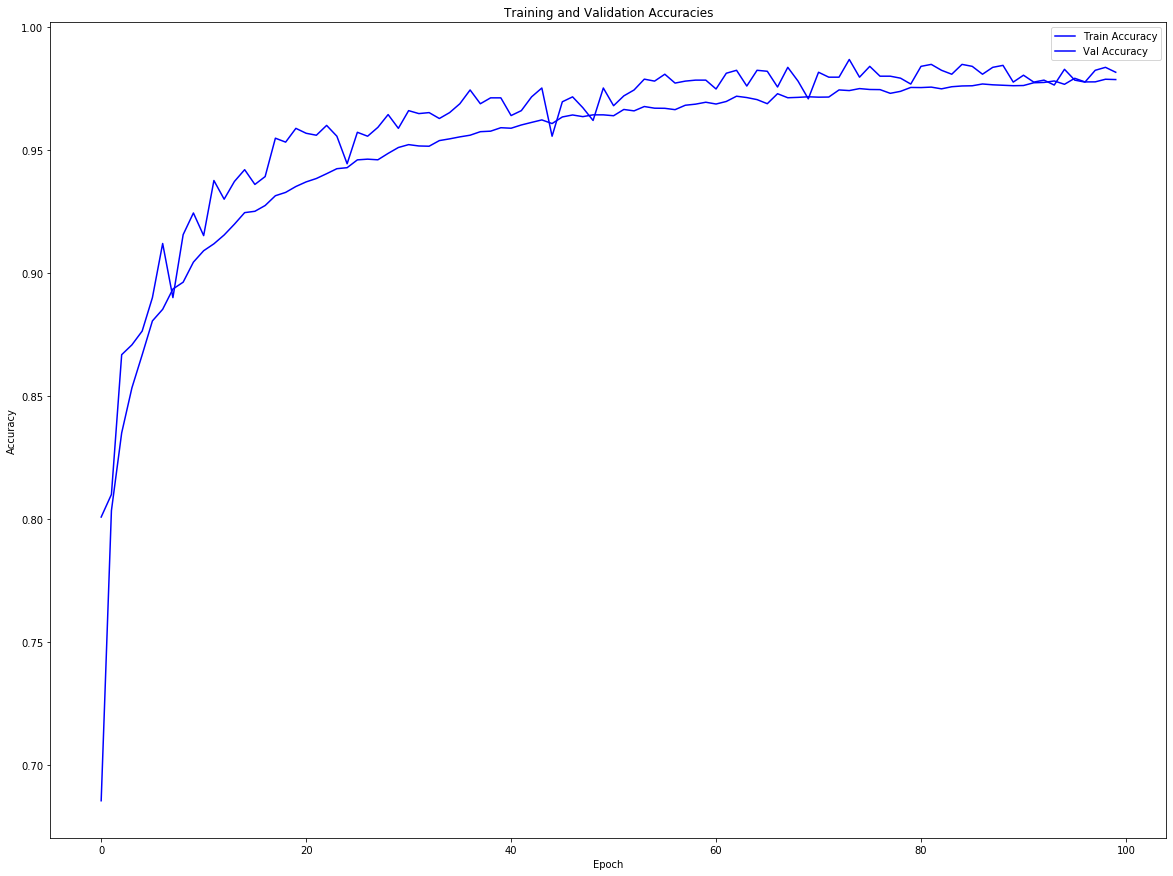

In [19]:
plt.figure(figsize=(20,15))

plt.plot(history.history['accuracy'], label= 'Train Accuracy', color= 'blue')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy', color= 'blue')
plt.legend()



plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

### Checking the Test set:

Now that the model has been trained and evaluated I'm going to see how it performs on unseen data. 

Now the data we used was 15 second clips of audio and some of the speakers may have been repeated. However each image will contain different words and inflections and data for further testing is scarce.

In [20]:
preds = model.predict(test_gen)

In [21]:
test_data['pred'] = np.where(preds >= 0.5, 1, 0)

test_data['pred'] = [str(i) for i in test_data['pred']]

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
len(test_data[test_data['Language'] == test_data['pred']]) / len(test_data)

0.9796081567373051

### Accuracy:

We got an accuracy of 97.9% 

There is definitely some room for improvement here. Which would be easy to produce given more training time on a larger dataset. 

But, since this is phase 1 of a 3 phase project I'm going to move on to phase 2 

### Saving:

But first I'm going to save the model and load it to verify my save worked

In [23]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [24]:
test_save = tf.keras.models.load_model('saved_model/my_model')

In [27]:
preds = test_save.predict(test_gen)

In [28]:
test_data['pred'] = np.where(preds >= 0.5, 1, 0)

test_data['pred'] = [str(i) for i in test_data['pred']]

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
len(test_data[test_data['Language'] == test_data['pred']]) / len(test_data)

0.9796081567373051

### Results:

We got the exact same results so it's safe to say the save worked properly!